In [155]:
!jupyter nbconvert linear_programming.ipynb --to python --no-prompt

[NbConvertApp] Converting notebook linear_programming.ipynb to python
[NbConvertApp] Writing 12207 bytes to linear_programming.py


In [154]:
#
# - Implement Simplex method
# - Apply to Monge-Kantorovich problem
# - Plot something nice
#

In [133]:
# TODO
# - more on plotting (visualization)
#   - 3d surface plot?
#   - should plot "non-conditional" value? (i.e. "G_ij * p_i" instead of "G_ij")
#   - wasserstein distance animation of "earth-move"
# - tweak "convexity" of distance function

In [1]:
import numpy as np
import ipywidgets as ipyw
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

import numba

In [146]:
#
# Simplex method
#

@numba.njit('i8[:](i8[:],)')
def perm_inv(p):
    p_inv = np.empty_like(p)
    for i in range(p.shape[0]):
        p_inv[p[i]] = i
    return p_inv

#
# Find optimal solution "x" or unbounded case "unbounded = True"
# Note that "b" of "A x = b" isn't necessary x is assumed to be initial solution (i.e. b = A x)
# 
# params:
# - c: f[n]
# - A: f[m, n]  (m <= n and A[:, :m] invertible)
# - x: f[n]     (initial basic solution with x[:m] is "basic" parts, so x[m:] == 0)
#
# returns:
# - x:         f[n]  (perm tells correspondence with original problem given as params)
# - perm:      i[n]  (first perm[:m] indicates basic indeces)
# - unbounded: b
#
# @numba.njit('Tuple((f8[:], i8[:], b1))(f8[:], f8[:, :], f8[:], b1)')
def simplex_method_solve(c, A, x, verbose):
    c, A, x = c.copy(), A.copy(), x.copy()
    m = A.shape[0]
    n = A.shape[1]    
    # assert m <= n
    # assert x.shape == (n,)
    # assert c.shape == (n,)
    # assert A[:, :m] (invertible)
    # assert np.all(x >= 0)
    # assert np.all(x[m:] == 0)
    
    # Keep track of original indeces order
    perm = np.arange(n)
    unbounded = False
    
    # For each iteration, update inverse of A[:, :m] via rank-1 trick (aka Sherman–Morrison formula)
    A1_inv = np.linalg.inv(A[:, :m])

    # TODO:
    # - Prove "swap" preserve invertibility of A[:, :m]
    # - or find counter example which doesn't.
    while True:
        c1 = c[:m]
        c2 = c[m:]
        A2 = A[:, m:]
        x1 = x[:m]
        # assert np.all(x[m:] == 0)

        #
        # Select "non-basic" swap index
        #
        B = A1_inv @ A2
        g = c2 - B.T @ c1
        j = np.argmin(g)
        
        #
        # Check optimality
        #
        if g[j] >= 0:
            break

        #
        # Select "basic" swap index and Compute magnitude (e) of new basic component
        #
        if np.all(B[:, j] <= 0):
            unbounded = True
            break
            
        # np.seterr(all='ignore')
        h = np.where(B[:, j] > 0, x1 / B[:, j], np.inf) 
        i = np.argmin(h)
        e = h[i]
        if verbose:
            print('swap: ', i, ' <--> ', m + j, ' with e = ', e)
        x1 -= e * B[:, j]

        #
        # Swap i <--> m + j
        #
        k = m + j
        x1[i] = e
        c[i], c[k] = c[k], c[i]
        A[:, i], A[:, k] = A[:, k], A[:, i].copy()
        perm[i], perm[k] = perm[k], perm[i]
        
        #
        # Update inverse via rank-1 trick with
        #   u = A[:, i] - A[:, k]
        #   v = [0 .. 1 .. 0]  ("1" at i-the coord)
        #
        u = A[:, i] - A[:, k]
        w = A1_inv @ u
        if np.allclose(w[i], -1):
            print('rank-1 inverse trick failed. (i.e. non invertible update)')
        A1_inv -= np.outer(w, A1_inv[i]) / (1 + w[i])

    return x, perm, unbounded

#
# params:
# - c: f[n]
# - A: f[m, n]
# - b: f[m] 
#
# returns:
# - x: f[n]
# - unbounded: b
# - non_admissible: b
# 
# @numba.njit('Tuple((f8[:], b1, b1))(f8[:], f8[:, :], f8[:], b1)')
def simplex_method(c, A, b, verbose):
    m = A.shape[0]
    n = A.shape[1]
    # assert m <= n
    # assert b.shape == (m,)
    # assert c.shape == (n,)
    # assert np.all(b >= 0)
    
    #
    # Find initial x0 by solving this problem first (aka. phase 1)
    #
    # inf <ones, y>
    # with A x + y = b
    #
    x = np.zeros(n)
    y = b
    c1 = np.concatenate((np.ones(m), np.zeros(n)))
    A1 = np.concatenate((np.eye(m), A), axis=-1)
    x1_init = np.concatenate((y, x))

    if verbose:
        print('phase-1 input:', c1, A1, x1_init, '', sep='\n')

    x1, perm1, unbounded = simplex_method_solve(c1, A1, x1_init, verbose)
    
    if verbose:
        print('', 'phase-1 result:', x1, perm1, unbounded, '', sep='\n')
    
    if unbounded:
        print('phase-1 returns unbounded. This must be a bug in simplex_method_solve.')
        return np.empty(1), True, False
        
    if np.any(perm1[:m] < m):
        # Couldn't find x s.t. A x = b (i.e. non admissible)
        return np.empty(1), False, True

    # Make discovered basic indeces aligned to the left and go for solving original problem
    perm1 = perm1[perm1 >= m] - m
    c2 = c[perm1]
    A2 = A[:, perm1]
    x2_init = x1[:n]
    
    if verbose:
        print('phase-2 input:', c2, A2, x2_init, '', sep='\n')
        
    x2, perm2, unbounded = simplex_method_solve(c2, A2, x2_init, verbose)
    
    if verbose:
        print('', 'phase-2 result:', x2, perm2, unbounded, '', sep='\n')
    
    # Restore original index order
    x_result = x2[perm_inv(perm1[perm2])]
    return x_result, unbounded, False

In [147]:
def test_simplex_method(verbose=False):
    m = 3
    n = 5
    c = np.random.rand(n)
    A = np.random.rand(m, n)
    b = np.random.rand(m)

    x, unbounded, non_admissible = simplex_method(c, A, b, verbose=verbose)
    result = sci_opt.linprog(c=c, A_eq=A, b_eq=b)
    
    if verbose:
        print(x, unbounded, non_admissible, '',
              result.x, result.message, sep='\n')
        
    if non_admissible:
        assert result.status == 2
    elif unbounded:
        assert result.statue == 1
    else:
        assert np.allclose(x, result.x)

def test_simplex_method__optimal__phase1(verbose=False):
    np.random.seed(1)
    test_simplex_method(verbose=verbose)

def test_simplex_method__optimal(verbose=False):
    np.random.seed(3)
    test_simplex_method(verbose=verbose)
    
def test_simplex_method__non_admissible(verbose=False):
    np.random.seed(0)
    test_simplex_method(verbose=verbose)

def test_simplex_method__unbounded(verbose=False):
    # TODO: test this case
    pass


test_simplex_method__optimal(verbose=False)
test_simplex_method__optimal__phase1(verbose=False)
test_simplex_method__non_admissible(verbose=False)

In [148]:
def test_simplex_method_solve__phase1(verbose=False):
    np.random.seed(0)
    m = 3
    n = 5
    A = np.random.randn(m, n)
    b = np.random.rand(m)
    c1 = np.concatenate((np.ones(m), np.zeros(n)))
    A1 = np.concatenate((np.eye(m), A), axis=-1)
    x1_init = np.concatenate((b, np.zeros(n)))
    
    if verbose: print(c1, A1, x1_init, sep='\n')
    x1, p, unbounded = simplex_method_solve(c1, A1, x1_init, verbose)
    
    if verbose: print('', x1, x1[perm_inv(p)], p, sep='\n')
    assert not unbounded
    assert np.allclose(A1 @ x1[perm_inv(p)], b)

def test_simplex_method_solve__phase2(verbose=False):
    m = 3
    n = 5
    c = np.random.randn(n)
    A = np.random.randn(m, n)
    x_init = np.zeros(n)
    x_init[:m] = np.random.rand(m)
    b = A @ x_init
    
    if verbose: print(c, A, x_init, np.dot(c, x_init), sep='\n')
    x, p, unbounded = simplex_method_solve(c, A, x_init,verbose)
    x_perm = x[perm_inv(p)]

    result = sci_opt.linprog(c=c, A_eq=A, b_eq=(A @ x_init))
    if verbose:
        print('', 
              x, p, unbounded, '',
              x_perm, np.dot(c, x_perm), '',
              result.x, np.dot(c, result.x), f"scipy: {result.message}",
              sep='\n')
    if not unbounded:
        assert np.allclose(x_perm, result.x)
        assert np.allclose(A @ x_perm, b)
        
def test_simplex_method_solve__phase2__unbounded(verbose=False):
    np.random.seed(1)
    test_simplex_method_solve__phase2(verbose=verbose)
    
def test_simplex_method_solve__phase2__bounded(verbose=False):
    np.random.seed(2)
    test_simplex_method_solve__phase2(verbose=verbose)


test_simplex_method_solve__phase1()
test_simplex_method_solve__phase2__unbounded()
test_simplex_method_solve__phase2__bounded()

In [149]:
@numba.njit('f8[:, :](i8, i8)')
def linprog_kantorovich_preprocess_A(m, n):
    """
    E.g. for m = 3 and n = 2
    
      1 . . 1 . .
      . 1 . . 1 .
      . . 1 . . 1
      1 1 1 . . .
      . . . 1 1 1
      
    It actually has a rank m + n - 1 (i.e. not surjective)
    """
    A = np.zeros((m + n, m * n))
    for j in range(n):
        k = j * m
        for i in range(m):
            A[i, k + i] = 1
            A[m + j, k + i] = 1
    return A

# params: f[m], f[n], f[m, n]
# returns:
# - c: f[m * n]
# - A: f[m + n, m * n]
# - b: f[m + n]
def linprog_kantorovich_preprocess(p, q, d):
    assert d.shape == (*p.shape, *q.shape)
    m = p.shape[0]
    n = q.shape[0]
    return (
        d.reshape(-1),
        linprog_kantorovich_preprocess_A(m, n),
        np.concatenate([p, q])
    )

@numba.njit('f8[:, :](i8, i8)')
def linprog_kantorovich_preprocess_A_v2(m, n):
    """
    E.g. for m = 4 and n = 3, it gives matrix with shape (m + n -1, m * n)
    
      1 . . . 1 . . . 1 . . .
      . 1 . . . 1 . . . 1 . .
      . . 1 . . . 1 . . . 1 .
      . . . 1 . . . 1 . . . 1
      . . . . 1 1 1 1 1 1 1 1
      . . . . . . . . 1 1 1 1
      
    """
    A = np.zeros((m + n - 1, m * n))
    for j in range(n):
        k = j * m
        for i in range(m):
            A[i, k + i] = 1
            A[m:m+j, k + i] = 1
    return A

#
# Above "linprog_kantorovich_preprocess_A" exactly has rank "m + n - 1",
# but, if p.sum() = q.sum(), then the redandunt constraint is safely satisfied (see matrix L below).
# This "preprocess_v2" will take care that redanduncy before passing to solver.
#
# This L can be derived via Gaussian elim. of linprog_kantorovich_preprocess_A.
#   L = np.zeros((m + n, m + n))
#   L[:m, :m] = np.eye(m)
#   L[m:, :m] = 1
#   L[m:, m:] = - np.tril(np.ones((n, n)))
#
#     1 . . .  . . .
#     . 1 . .  . . .
#     . . 1 .  . . .
#     . . . 1  . . .
#     1 1 1 1 -1 . .
#     1 1 1 1 -1-1 .
#     1 1 1 1 -1-1-1
#
# params: f[m], f[n], f[m, n]
# returns:
# - c: f[m * n]
# - A: f[m + n - 1, m * n]
# - b: f[m + n - 1]
def linprog_kantorovich_preprocess_v2(p, q, d):
    assert d.shape == (*p.shape, *q.shape)
    assert np.allclose(p.sum(), q.sum())
    m = p.shape[0]
    n = q.shape[0]    
    A = linprog_kantorovich_preprocess_A_v2(m, n)
    q_ = 1 - np.cumsum(q)[:n-1]
    return (
        d.reshape(-1),
        A,
        np.concatenate([p, q_])
    )

def linprog_kantorovich_postprocess(x, d):
    return x.reshape(d.shape)

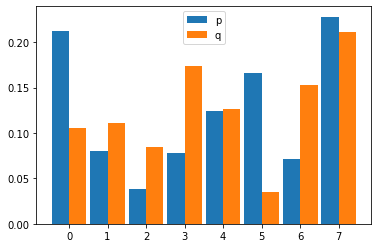

In [150]:
#
# Example (discrete case of Monge-Kantrovich problem)
#

# Number of (discrete) points
N = 2**3

# Distributions
p = np.random.rand(N); p /= p.sum()
q = np.random.rand(N); q /= q.sum()

# Plotting
fig, ax = plt.subplots()
ax.bar(np.arange(N) - .45/2, p, width=.45, label='p', color='C0')
ax.bar(np.arange(N) + .45/2, q, width=.45, label='q', color='C1')
ax.legend()

In [151]:
# Distance matrix (aka. cost fuction)
# exponent controls convexity of function (should be interesting to play around changing)
exponent = 5. 
d = np.abs(np.arange(N).reshape(-1, 1) - np.arange(N)) ** exponent

# Convert to standard form
c, A, b = linprog_kantorovich_preprocess_v2(p, q, d)

# Solve
result = sci_opt.linprog(c=c, A_eq=A, b_eq=b)
print(result.message)
g = linprog_kantorovich_postprocess(result.x, d)

# Compare with my simplex method implementation
assert np.allclose(simplex_method(c, A, b, verbose=False)[0], result.x)

Optimization terminated successfully.


[[], []]

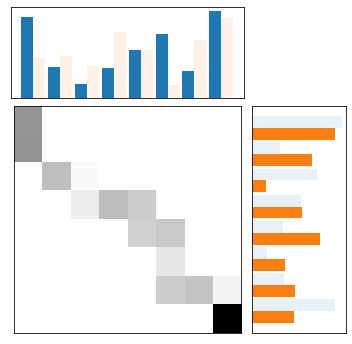

In [152]:
# Plotting
fig, axes = plt.subplots(
        2, 2, figsize=(6, 6),
        subplot_kw=dict(xticks=[], yticks=[]),
        gridspec_kw=dict(wspace=.05, hspace=.05, width_ratios=[2, .8], height_ratios=[.8, 2]))

axes[0, 1].remove()

axes[0, 0].bar(np.arange(N) - .45/2, p, width=.45, alpha=1., color='C0')
axes[0, 0].bar(np.arange(N) + .45/2, q, width=.45, alpha=.1, color='C1')

axes[1, 1].barh(np.arange(N) + .45/2, p, height=.45, alpha=.1, color='C0')
axes[1, 1].barh(np.arange(N) - .45/2, q, height=.45, alpha=1., color='C1')


axes[0, 0].set(ylim=[0, max(p.max(), q.max()) + .01])
axes[1, 1].set(xlim=[0, max(p.max(), q.max()) + .01])

axes[1, 0].matshow(g, cmap='Greys')
axes[1, 0].set(xticks=[], yticks=[])